## PREPROCESSING
### Get the dataset
Load the dataset, split it in two for trainin and validation. As in the Reference model provided by [Lyft](https://level5.lyft.com/), a dataframe with one scene per row is created.

In [1]:
DATASET_VERSION = 'v1.02-train'
DATASET_ROOT = '../local_th/data/'

#The code will generate data, visualization and model checkpoints
ARTIFACTS_FOLDER = "./artifacts"

In [2]:
%load_ext autoreload

from datetime import datetime
from functools import partial
import glob
#Disabled for numpy and opencv: avod has opencv and numpy versions for several methods
from multiprocessing import Pool

import os
#os.environ["OMP_NUM_THREADS"] = "1"

import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import pandas as pd
import cv2
import PIL
from PIL import Image
import numpy as np
from tqdm import tqdm, tqdm_notebook
import argparse
import scipy
import scipy.ndimage
import scipy.special
from scipy.spatial.transform import Rotation as R

from lyft_dataset_sdk.lyftdataset import LyftDataset
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud, Box, Quaternion
from lyft_dataset_sdk.utils.geometry_utils import view_points, transform_matrix


In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.4) 
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True, gpu_options=gpu_options))
gpus[0]

1 Physical GPUs, 1 Logical GPU
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5



PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

In [4]:
level5data = LyftDataset(json_path=DATASET_ROOT + "/v1.02-train", data_path=DATASET_ROOT, verbose=True)
os.makedirs(ARTIFACTS_FOLDER, exist_ok=True)

9 category,
18 attribute,
4 visibility,
15991 instance,
8 sensor,
128 calibrated_sensor,
149072 ego_pose,
148 log,
148 scene,
18634 sample,
149072 sample_data,
539765 sample_annotation,
1 map,
Done loading in 4.7 seconds.
Reverse indexing ...
Done reverse indexing in 1.6 seconds.


## <font color="pink">TRAINING</font>
Based on the [AVOD algorithm](https://github.com/kujason/avod), we train the dataset. 
The goal is to study how the accuracy changes based on the type of sensors in input, and their number, thus changes to the AVOD algorithm have been made. Here we keep the two stage model.
Will be divided in steps, to mimick the divisions made by AVOD's authors in the code.

With respect to the original AVOD code, the following changes have been made:
<li> Upgrades for compatibity issues with tensorflow 2.0: migrated from slim libs to keras Sequential</li>
<li> Changes to support single type input </li>
<li> VGGs take as input Lyft-style dataset </li>



In [5]:
import avod
from avod.core import trainer

<b>RPN MODEL</b>: It is the fist subnetwork that makes up the double stage AVOD algorithm. It uses two VGGs, one for images, one for LiDar, to find the bottleneck.
Img VGG and Bev VGG have the same strucure, just have input from different sources. 

<b>VGG:</b> VGG is a convolutional neural network model. Here simplified model wrt K. Simonyan and A. Zisserman's model proposed in the paper "Very Deep Convolutional Networks for Large-Scale Image Recognition".
Basically, it lacks dense layers at the end, and the last group of conv layers is smaller that theirs.
Two VGGs, one for BEV, one for Images

In [6]:
import anchor_helper
from frame_helper import FrameCalibrationData
import frame_helper
import bev_helper

In [7]:
from PIL import Image

## Test this part!!

Tests and results for the RPN model part. The following changes to the model were done after errors/issues with testing:
<li>Maybe change the use of placeholders in the future, to fit with eager execution (shorter code)</li>
<li>Some internal keras os function rises a warning, something will be depreated, doesn't tell where and what function exactly</li>

In [8]:
import avod.builders.config_builder_util as config_build
config_path = 'avod/configs/unittest_model.config'
pipe_path = 'avod/configs/unittest_pipeline.config'
model_config = config_build.get_model_config_from_file(config_path)
pipeline_config=config_build.get_configs_from_pipeline_file(pipe_path, "val")
#rpn_model = RpnModel(model_config, pipeline_config[3],
 #                         train_val_test="val",
   #                       dataset=level5data)
# array=rpn_model.feed_input(5)
#predictions = rpn_model.build()
#tensor=tf.convert_to_tensor(array)


<b> AVOD MODEL: </b> second stage detector for the AVOD algorithm. It uses FPN as feature extractors.
<b> FPN: </b> Feature Pyramid Network (FPN) is a feature extractor designed for such pyramid concept with accuracy and speed in mind. It replaces the feature extractor of detectors like Faster R-CNN and generates multiple feature map layers (multi-scale feature maps) with better quality information than the regular feature pyramid for object detection. [Understanding Feature Pyramid Networks for object detection (FPN)](https://medium.com/@jonathan_hui/understanding-feature-pyramid-networks-for-object-detection-fpn-45b227b9106c)

In [61]:
dataset=level5data
my_scene = dataset.scene[5]

        
voxel_size = (0.4,0.4,1.5)
z_offset = -2.0
#arbitrary shape, must be square though!
bev_shape = (336,336, 3)
        
# Only handle one sample at a time for now
my_sample_token = my_scene["first_sample_token"]
my_last_sample_token = my_scene["last_sample_token"]
sample = dataset.get('sample', my_sample_token)
tok=sample['data']["CAM_FRONT"]
tok_bev=sample['data']["LIDAR_TOP"]
iboxes=dataset.get_boxes(tok)   
bboxes=dataset.get_boxes(tok_bev)
data_path, boxes, camera_intrinsic = dataset.get_sample_data(
                tok_bev)
data_path, uboxes, camera_intrinsic = dataset.get_sample_data(
                tok)
x=iboxes[0].wlh
v=bboxes[0].center
y=iboxes[0].corners(0.3)

classes=[]
for i in dataset.category:
    classes.append(i.get("name"))

# print(iboxes[0].corners(),"\n", uboxes[0].corners())
# anchors_info, obj_classes, label_classes, label_anchors, label_boxes_3d = preproc_helper.load_sample_info(tok, classes, dataset)

In [62]:
# Network input data: loop to get batch info
import box_helper
import bev_helper
import frame_helper
# import preproc_helper
import io
from typing import Tuple, List

classes=[]
for i in dataset.category:
    classes.append(i.get("name"))

img_input_list=[]
img_target=[]
bev_input_list=[]
ground_plane_list=[]
lidar=[]

with tf.device('/GPU:0'):
    while my_sample_token!=my_last_sample_token:

        sample = dataset.get('sample', my_sample_token)
        sample_name = sample.get("token")
        img_data = dataset.get('sample_data', sample['data']["CAM_FRONT"])
        camera_token=img_data.get("token")

        tok=sample['data']["CAM_FRONT"]
        boxes=dataset.get_boxes(tok) 

        ego_pose = dataset.get("ego_pose", img_data["ego_pose_token"])
        data_path, boxes, camera_intrinsic = dataset.get_sample_data(camera_token)
        data = Image.open(data_path)

#         anchors_info, obj_classes, label_classes, label_anchors, label_boxes_3d = preproc_helper.load_sample_info(sample_name, classes, dataset)
    #     fig, ax = plt.subplots(1, 1, figsize=(9, 16))

    #     # Show image.
    #     ax.imshow(data)

    #     # Show boxes.
    #     for box in boxes:
    #         c = np.array(box_helper.get_color(box.name)) / 255.0
    #         box.render(ax, view=camera_intrinsic, normalize=True, colors=(c, c, c))
    #     ax.axis('off')
    #     ax.set_title(img_data['channel'])
    #     ax.set_aspect('equal')

    #     # you can get a high-resolution image as numpy array!!
    #     plot_img_np = box_helper.get_img_from_fig(fig)


    #     # Limit visible range.
    #     ax.set_xlim(0, data.size[0])
    #     ax.set_ylim(data.size[1], 0)

    #    img_target.append(plot_img_np)
        bev_input = dataset.get('sample_data', sample['data']["LIDAR_TOP"])
        bev_data = bev_input
        bev_token= bev_input.get("token")
        lidar_data = dataset.get("sample_data", bev_token)
        lidar_filepath = dataset.get_sample_data_path(bev_token)
        ego_pose = dataset.get("ego_pose", lidar_data["ego_pose_token"])
        calibrated_sensor_lidar = dataset.get("calibrated_sensor", lidar_data["calibrated_sensor_token"])
        global_from_car = transform_matrix(ego_pose['translation'], Quaternion(ego_pose['rotation']), inverse=False)
        car_from_sensor_lidar = transform_matrix(calibrated_sensor_lidar['translation'], Quaternion(calibrated_sensor_lidar['rotation']),
                                                  inverse=False)
        lidar_pointcloud = LidarPointCloud.from_file(lidar_filepath)
        lidar_pointcloud.transform(car_from_sensor_lidar)
        lidar.append(lidar_pointcloud.points)
        x=sample["data"]["LIDAR_TOP"]
        bevboxes=dataset.get_boxes(x)
        bev = bev_helper.create_voxel_pointcloud(lidar_pointcloud.points, bev_shape, voxel_size=voxel_size, z_offset=z_offset)
        #ego_centric_map = bev_helper.get_semantic_map_around_ego(map_mask, ego_pose, voxel_size=0.4, output_shape=(336,336)) 
        bev_array = bev_helper.normalize_voxel_intensities(bev)
        bev_input_list.append(bev_array)

        file_name=dataset.get_sample_data_path(camera_token)
        image1 = Image.open(file_name)
        # compress image, it is too big
        # convert image to numpy array
        image = image1.resize((306,256), Image.ANTIALIAS)
        img_array = np.asarray(image)
        if img_input_list is not None:
            img_input_list.append(img_array)

        cam_front_token = dataset.get('sample_data', sample['data']["CAM_FRONT"])
        cam_front_data = cam_front_token.get("calibrated_sensor_token")
        cam_front_calib = dataset.get("calibrated_sensor", cam_front_data )
        cam_front_coords = cam_front_calib.get("translation")

        cam_front_left_token = dataset.get('sample_data', sample['data']["CAM_FRONT_LEFT"])
        cam_front_left_data = cam_front_left_token.get("calibrated_sensor_token")
        cam_front_left_calib = dataset.get("calibrated_sensor", cam_front_left_data )
        cam_front_left_coords = cam_front_left_calib.get("translation")

        cam_front_right_token = dataset.get('sample_data', sample['data']["CAM_FRONT_RIGHT"])
        cam_front_right_data = cam_front_right_token.get("calibrated_sensor_token")
        cam_front_right_calib = dataset.get("calibrated_sensor", cam_front_right_data )
        cam_front_right_coords = cam_front_right_calib.get("translation")

        ground_plane = frame_helper.get_ground_plane_coeff(cam_front_coords, cam_front_left_coords, cam_front_right_coords)
        ground_plane_list.append(ground_plane)
        
        token=img_data.get("calibrated_sensor_token") 
        stereo_calib_p2 = frame_helper.read_calibration(token, dataset)

        my_sample_token = dataset.get("sample", my_sample_token)["next"]



In [63]:
from lyft_dataset_sdk.utils.geometry_utils import view_points
import matplotlib.patches as patches

In [64]:
img_input=np.asarray(img_input_list)
bev_input=np.asarray(bev_input_list)
#img_targetnp=np.asarray(img_target)

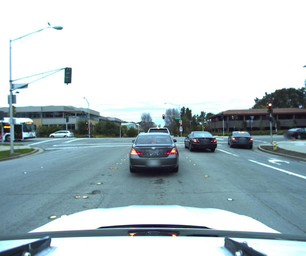

In [65]:
a = Image.fromarray(img_input[0])
a

In [67]:
with tf.device('/GPU:0'):
    #inputs_vgg = tf.keras.layers.Input(shape=(224,224,3))
    vgg16 = tf.keras.applications.VGG16(include_top=False, input_shape=(256,306,3),weights='imagenet')
    vgg16.summary()
    #bev_data = tf.keras.applications.vgg16.preprocess_input(bev_input)
    #bev_features=vgg16.predict(bev_data)
#     #exclude fully connected
#     output = vgg16.layers[-3].output
#     #struggle with memory
img_data = tf.keras.applications.vgg16.preprocess_input(img_input)
img_features=vgg16.predict(img_data)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 256, 306, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 306, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 306, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 153, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 153, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 153, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 76, 128)       0     

[-1.58155607  0.36032334  8.41384456] [0.53375 1.29375 0.41475]


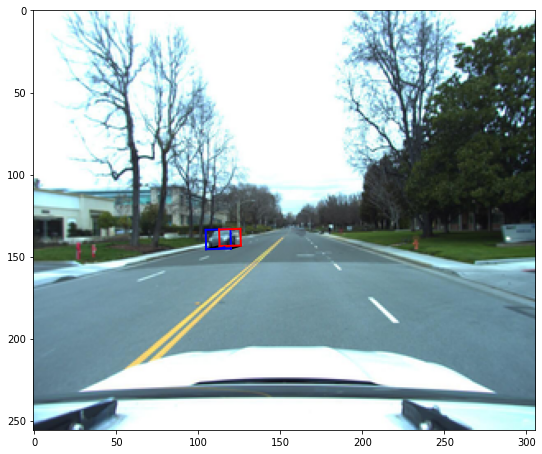

In [70]:
w_stride=16
h_stride=16 
f_map_img_h=8
f_map_img_w=9
img_h=256
img_w=306
s_x=np.arange(0,f_map_img_w)*w_stride
s_y=np.arange(0,f_map_img_h)*h_stride
s_x, s_y=np.meshgrid(s_x,s_y)
shifts=np.vstack((s_x.ravel(), s_y.ravel(), s_x.ravel(), s_y.ravel())).transpose()

def gen_anchors(w_stride, h_stride, ratios=[0.5,1.2], scales=np.asarray([8,16,32])):
    base_anchor = np.array([1, 1, w_stride, h_stride]) - 1
    ratio_anchors = _ratio_enum(base_anchor, ratios)
    anchors = np.vstack([_scale_enum(ratio_anchors[i, :], scales)
                         for i in range(ratio_anchors.shape[0])])
    return anchors
def _ratio_enum(anchor, ratios):
    """
    Enumerate a set of anchors for each aspect ratio wrt an anchor.
    """

    w, h, x_ctr, y_ctr = _whctrs(anchor)
    size = w * h
    size_ratios = size / ratios
    ws = np.round(np.sqrt(size_ratios))
    hs = np.round(ws * ratios)
    anchors = _mkanchors(ws, hs, x_ctr, y_ctr)
    return anchors
def _mkanchors(ws, hs, x_ctr, y_ctr):
    """
    Given a vector of widths (ws) and heights (hs) around a center
    (x_ctr, y_ctr), output a set of anchors (windows).
    """

    ws = ws[:, np.newaxis]
    hs = hs[:, np.newaxis]
    anchors = np.hstack((x_ctr - 0.5 * (ws - 1),
                         y_ctr - 0.5 * (hs - 1),
                         x_ctr + 0.5 * (ws - 1),
                         y_ctr + 0.5 * (hs - 1)))
    return anchors
def _whctrs(anchor):
    """
    Return width, height, x center, and y center for an anchor (window).
    """

    w = anchor[2] - anchor[0] + 1
    h = anchor[3] - anchor[1] + 1
    x_ctr = anchor[0] + 0.5 * (w - 1)
    y_ctr = anchor[1] + 0.5 * (h - 1)
    return w, h, x_ctr, y_ctr
def _scale_enum(anchor, scales):
    """
    Enumerate a set of anchors for each scale wrt an anchor.
    """

    w, h, x_ctr, y_ctr = _whctrs(anchor)
    ws = w * scales
    hs = h * scales
    anchors = _mkanchors(ws, hs, x_ctr, y_ctr)
    return anchors

def loss_cls(y_true, y_pred):
    condition = K.not_equal(y_true, -1)
    indices = K.tf.where(condition)

    target = K.tf.gather_nd(y_true, indices)
    output = K.tf.gather_nd(y_pred, indices)
    loss = K.binary_crossentropy(target, output)
    return K.mean(loss)

def smoothL1(y_true, y_pred):
    nd=K.tf.where(K.tf.not_equal(y_true,0))
    y_true=K.tf.gather_nd(y_true,nd)
    y_pred=K.tf.gather_nd(y_pred,nd)
    x = K.tf.losses.huber_loss(y_true,y_pred)
#     x   = K.switch(x < HUBER_DELTA, 0.5 * x ** 2, HUBER_DELTA * (x - 0.5 * HUBER_DELTA))
    return x

base_anchors=gen_anchors(w_stride,h_stride)
num_feature_map=f_map_img_h*f_map_img_w
num_anchors_per_tile=6
all_anchors = (base_anchors.reshape((1, num_anchors_per_tile, 4)) + shifts.reshape((1, num_feature_map, 4)).transpose((1, 0, 2)))
border=0
inds_inside = np.where(
        (all_anchors[:, 0] >= -border) &
        (all_anchors[:, 1] >= -border) &
        (all_anchors[:, 2] < img_w+border ) &  # width
        (all_anchors[:, 3] < img_h+border)    # height
)[0]
anchors=all_anchors[inds_inside]
#print(anchors/4)
c2=np.array([[221, 0, 157],[0, 221, 129],[0, 0, 1]])
x=[camera_intrinsic[0]/4, camera_intrinsic[1]/4, camera_intrinsic[2]]
x=np.asarray(x)
fig, ax = plt.subplots(1, 1, figsize=(9, 16))
ax.imshow(image)
h=boxes[0].center
boxes[0].center=h
# v=boxes[0].wlh
print(h/4, v/4)
boxes[0].render(ax, view=x, normalize=True)
#ax.plot([0.13, 0.14], color="c")
rect = patches.Rectangle(( 7., 18.),52.75,  41.75,linewidth=1,edgecolor="r")
x=view_points(uboxes[0].corners(), np.eye(3), normalize=True)

# Add the patch to the Axes
# ax.add_patch(rect)


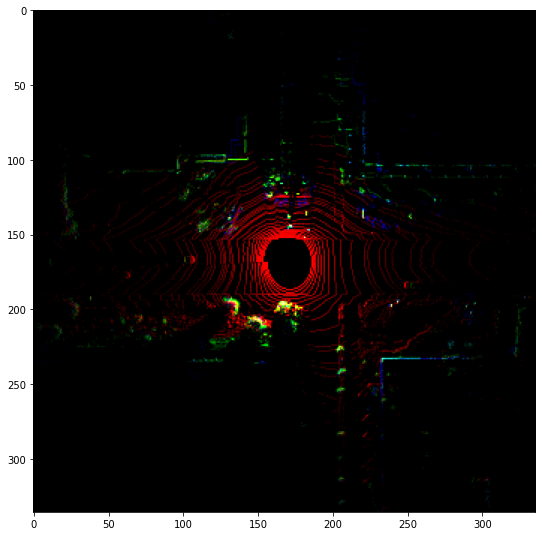

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(9, 16))
bev1 = bev_helper.normalize_voxel_intensities(bev)
bev2=bev
ax.imshow(bev1)
ego_p=dataset.get("ego_pose", lidar_data["ego_pose_token"])
bev_helper.move_boxes_to_car_space(bevboxes, ego_pose)
bev_helper.scale_boxes(bevboxes, 0.8)
#bevboxes


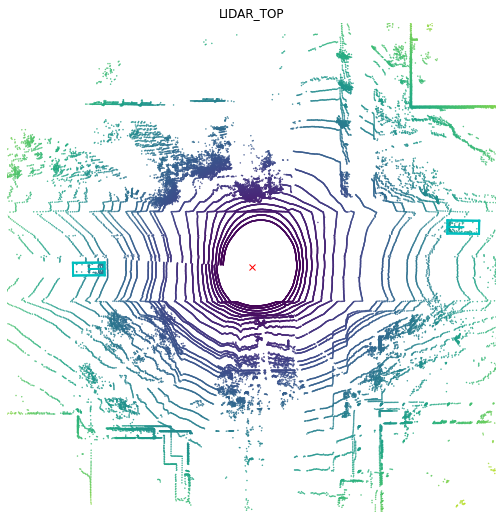

In [72]:
from lyft_dataset_sdk.utils.geometry_utils import BoxVisibility, box_in_image, view_points
def visualize_lidar_of_sample(sample_token, axes_limit=80):
    sample = level5data.get("sample", sample_token)
    sample_lidar_token = sample["data"]["LIDAR_TOP"]
    level5data.render_sample_data(sample_lidar_token, axes_limit=axes_limit)
#visualize_lidar_of_sample(sample_name)
sample = level5data.get("sample", sample_name)
sample_lidar_token = sample["data"]["LIDAR_TOP"]
_, boxes, _ = dataset.get_sample_data(sample_lidar_token, box_vis_level=BoxVisibility.ANY, flat_vehicle_coordinates=True)

sd_record = dataset.get("sample_data", sample_lidar_token)
# Get aggregated point cloud in lidar frame.
sample_rec = dataset.get("sample", sd_record["sample_token"])
chan = sd_record["channel"]
ref_chan = "LIDAR_TOP"
pc, times = LidarPointCloud.from_file_multisweep(
    dataset, sample_rec, chan, ref_chan, num_sweeps=1
)

# Compute transformation matrices for lidar point cloud
cs_record = dataset.get("calibrated_sensor", sd_record["calibrated_sensor_token"])
pose_record = dataset.get("ego_pose", sd_record["ego_pose_token"])
vehicle_from_sensor = np.eye(4)
vehicle_from_sensor[:3, :3] = Quaternion(cs_record["rotation"]).rotation_matrix
vehicle_from_sensor[:3, 3] = cs_record["translation"]

ego_yaw = Quaternion(pose_record["rotation"]).yaw_pitch_roll[0]
rot_vehicle_flat_from_vehicle = np.dot(
    Quaternion(scalar=np.cos(ego_yaw / 2), vector=[0, 0, np.sin(ego_yaw / 2)]).rotation_matrix,
    Quaternion(pose_record["rotation"]).inverse.rotation_matrix,
)

vehicle_flat_from_vehicle = np.eye(4)
vehicle_flat_from_vehicle[:3, :3] = rot_vehicle_flat_from_vehicle

# Init axes.
_, ax = plt.subplots(1, 1, figsize=(9, 9))


# Show point cloud.
points = view_points(
    pc.points[:3, :], np.dot(vehicle_flat_from_vehicle, vehicle_from_sensor), normalize=False
)
dists = np.sqrt(np.sum(pc.points[:2, :] ** 2, axis=0))
colors = np.minimum(1, dists / 40 / np.sqrt(2))
ax.scatter(points[0, :], points[1, :], c=colors, s=0.2)

# Show ego vehicle.
ax.plot(0, 0, "x", color="red")

# Show boxes.
for box in boxes:
    box.render(ax, view=np.eye(4), colors=("c", "c", "c"))

# Limit visible range.
ax.set_xlim(-40, 40)
ax.set_ylim(-40, 40)
ax.axis("off")
ax.set_title(sd_record["channel"])
ax.set_aspect("equal")

def get_boxes(boxes):
    corners = view_points(boxes.corners(), view, normalize=normalize)[:2, :]

    def draw_rect(selected_corners, color):
        prev = selected_corners[-1]
        
        for corner in selected_corners:
            axis.plot([prev[0], corner[0]], [prev[1], corner[1]], color=color, linewidth=linewidth)
            prev = corner
            
    # Draw front (first 4 corners) and rear (last 4 corners) rectangles(3d)/lines(2d)
    draw_rect(corners.T[:4], colors[0])
    draw_rect(corners.T[4:], colors[1])

    # Draw line indicating the front
    center_bottom_forward = np.mean(corners.T[2:4], axis=0)
    center_bottom = np.mean(corners.T[[2, 3, 7, 6]], axis=0)
    axis.plot(
        [center_bottom[0], center_bottom_forward[0]],
        [center_bottom[1], center_bottom_forward[1]],
        color=colors[0],
        linewidth=linewidth,
    )

In [75]:
#now build the rpn and get proposals from the anchors
k=9 #anchor number for each point
feature_map_tile = tf.keras.layers.Input(shape=(None,None,512))
convolution_3x3 = tf.keras.layers.Conv2D(
    filters=512,
    kernel_size=(3, 3),
    padding='same',
    name="3x3"
)(feature_map_tile)

output_deltas = tf.keras.layers.Conv2D(
    filters= 4 * k,
    kernel_size=(1, 1),
    activation="linear",
    kernel_initializer="uniform",
    name="deltas1"
)(convolution_3x3)

output_scores = tf.keras.layers.Conv2D(
    filters=1 * k,
    kernel_size=(1, 1),
    activation="sigmoid",
    kernel_initializer="uniform",
    name="scores1"
)(convolution_3x3)

rpn_model = tf.keras.Model(inputs=[feature_map_tile], outputs=[output_scores, output_deltas])
rpn_model.compile(optimizer='adam', loss={'scores1':loss_cls, 'deltas1':smoothL1})
res=rpn_model.predict(img_features)


In [76]:
def bbox_transform_inv(boxes, deltas):
    if boxes.shape[0] == 0:
        return np.zeros((0, deltas.shape[1]), dtype=deltas.dtype)
    boxes = boxes.astype(deltas.dtype, copy=False)

    widths = boxes[:, 2] - boxes[:, 0] + 1.0
    heights = boxes[:, 3] - boxes[:, 1] + 1.0
    ctr_x = boxes[:, 0] + 0.5 * widths
    ctr_y = boxes[:, 1] + 0.5 * heights

    dx = deltas[:, 0::4]
    dy = deltas[:, 1::4]
    dw = deltas[:, 2::4]
    dh = deltas[:, 3::4]
    pred_ctr_x = dx * widths[:, np.newaxis] + ctr_x[:, np.newaxis]
    pred_ctr_y = dy * heights[:, np.newaxis] + ctr_y[:, np.newaxis]
    pred_w = np.exp(dw) * widths[:, np.newaxis]
    pred_h = np.exp(dh) * heights[:, np.newaxis]

    pred_boxes = np.zeros(deltas.shape, dtype=deltas.dtype)
    print(pred_boxes.shape, pred_ctr_x.shape)
    # x1
    pred_boxes[:, 0::4] = pred_ctr_x - 0.5 * pred_w
    # y1
    pred_boxes[:, 1::4] = pred_ctr_y - 0.5 * pred_h
    # x2
    pred_boxes[:, 2::4] = pred_ctr_x + 0.5 * pred_w
    # y2
    pred_boxes[:, 3::4] = pred_ctr_y + 0.5 * pred_h

    return pred_boxes

scores=res[0]
scores=scores.reshape(-1,1)
deltas=res[1]
print(res[1])
deltas=np.reshape(deltas,(-1,4))
proposals =bbox_transform_inv(all_anchors, deltas)
proposals = clip_boxes(proposals, (h_w[0],h_w[1]))
# remove small boxes, here threshold is 40 pixel
keep = filter_boxes(proposals, 40)
proposals = proposals[keep, :]
scores = scores[keep]

[[[[ 2.57508659e+00  1.51154590e+00 -1.70249224e+00 ...  5.13201579e-02
    -3.76322484e+00 -1.21223485e+00]
   [ 1.62795174e+00  8.21048141e-01  2.75760591e-02 ... -2.18645525e+00
    -8.29837322e-01 -7.74033248e-01]
   [ 4.80532551e+00  1.74418902e+00 -6.24862969e-01 ... -2.27754068e+00
    -1.60870671e+00  6.54811442e-01]
   ...
   [-7.93667257e-01 -4.71649051e-01 -6.65745020e-01 ...  5.32037020e-01
     9.41020489e-01  3.92991662e-01]
   [-4.49046880e-01 -5.00793636e-01 -8.38283896e-01 ...  6.44757450e-01
     1.50175774e+00  1.17519118e-01]
   [-9.00866032e-01 -3.96705717e-01  1.40340418e-01 ...  1.45453537e+00
     6.25094712e-01  6.58588946e-01]]

  [[-3.87150198e-01  3.81529522e+00  2.99979448e+00 ...  1.27228069e+00
    -1.52399206e+00 -1.15564728e+00]
   [-2.26671085e-01  1.01860130e+00  3.79886556e+00 ... -4.40716171e+00
    -3.17853117e+00  2.28457189e+00]
   [ 3.31820226e+00  3.46711946e+00  6.06041431e+00 ...  1.12511027e+00
     8.58912826e-01  7.04122365e-01]
   ...
   

ValueError: could not broadcast input array from shape (72,81000,4) into shape (81000,1)